# Génération de Texte avec LSTM - Les Œuvres Complètes de Shakespeare

Ce notebook implémente un modèle de génération de texte utilisant un réseau de neurones LSTM (Long Short-Term Memory) pour apprendre et générer du texte dans le style de Shakespeare.

## Objectifs
- Télécharger et préparer le corpus de Shakespeare
- Construire un modèle LSTM avec couche d'embedding
- Entraîner le modèle sur le corpus
- Générer du nouveau texte dans le style de Shakespeare

In [1]:
%pip install tensorflow


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importation des bibliothèques nécessaires
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import requests
import re
import os
import pickle
from collections import Counter

# Configuration
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Désactiver les avertissements
import warnings
warnings.filterwarnings('ignore')

2026-02-12 01:24:54.661443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
Keras version: 3.13.2


## 1. Préparation des Données

### 1.1 Téléchargement du corpus

In [3]:
# URL du corpus de Shakespeare sur Project Gutenberg
url = "https://www.gutenberg.org/files/100/100-0.txt"

# Téléchargement du fichier
print("Téléchargement du corpus de Shakespeare...")
response = requests.get(url)
response.encoding = 'utf-8'
raw_text = response.text

print(f"Taille du corpus brut: {len(raw_text)} caractères")
print(f"Nombre de lignes: {len(raw_text.splitlines())}")
print("\nAperçu des 500 premiers caractères:")
print(raw_text[:500])

Téléchargement du corpus de Shakespeare...
Taille du corpus brut: 5359444 caractères
Nombre de lignes: 196022

Aperçu des 500 premiers caractères:
*** START OF THE PROJECT GUTENBERG EBOOK 100 ***




The Complete Works of William Shakespeare

by William Shakespeare




                    Contents

    THE SONNETS
    ALL’S WELL THAT ENDS WELL
    THE TRAGEDY OF ANTONY AND CLEOPATRA
    AS YOU LIKE IT
    THE COMEDY OF ERRORS
    THE TRAGEDY OF CORIOLANUS
    CYMBELINE
    THE TRAGEDY OF HAMLET, PRINCE OF DENMARK
    THE FIRST PART OF KING HENRY THE FOURTH
    THE SECOND PART OF KING HENRY THE FOURTH
    THE LIFE OF KING HENRY THE FIFTH
  


### 1.2 Nettoyage des données

In [4]:
def clean_gutenberg_text(text):
    """
    Nettoie le texte téléchargé de Project Gutenberg en retirant:
    - Les en-têtes et pieds de page
    - Les informations de copyright
    - Les caractères spéciaux non pertinents
    """
    # Trouver le début du texte réel (après l'en-tête)
    # L'en-tête se termine généralement par "*** START OF"
    start_markers = [
        "*** START OF THE PROJECT GUTENBERG EBOOK",
        "***START OF THE PROJECT GUTENBERG EBOOK",
        "*** START OF THIS PROJECT GUTENBERG EBOOK"
    ]
    
    start_idx = 0
    for marker in start_markers:
        idx = text.find(marker)
        if idx != -1:
            # Trouver la fin de la ligne et prendre la ligne suivante
            start_idx = text.find('\n', idx) + 1
            break
    
    # Trouver la fin du texte réel (avant le pied de page)
    # Le pied de page commence généralement par "*** END OF"
    end_markers = [
        "*** END OF THE PROJECT GUTENBERG EBOOK",
        "***END OF THE PROJECT GUTENBERG EBOOK",
        "*** END OF THIS PROJECT GUTENBERG EBOOK"
    ]
    
    end_idx = len(text)
    for marker in end_markers:
        idx = text.find(marker)
        if idx != -1:
            end_idx = idx
            break
    
    # Extraire le texte principal
    text = text[start_idx:end_idx]
    
    # Nettoyer les caractères spéciaux et normaliser les espaces
    # Garder les sauts de ligne mais normaliser les espaces multiples
    text = re.sub(r'[^\w\s\n\.,!?;:\'\"-]', '', text)
    text = re.sub(r'\s+', ' ', text)  # Remplacer les espaces multiples par un seul
    text = re.sub(r'\n\s*\n', '\n', text)  # Remplacer les lignes vides multiples par une seule
    
    return text.strip()

# Nettoyage du texte
print("Nettoyage du texte...")
cleaned_text = clean_gutenberg_text(raw_text)

print(f"\nTaille du corpus nettoyé: {len(cleaned_text)} caractères")
print(f"Nombre de mots: {len(cleaned_text.split())}")
print("\nAperçu du texte nettoyé (500 premiers caractères):")
print(cleaned_text[:500])

Nettoyage du texte...

Taille du corpus nettoyé: 5256937 caractères
Nombre de mots: 963425

Aperçu du texte nettoyé (500 premiers caractères):
The Complete Works of William Shakespeare by William Shakespeare Contents THE SONNETS ALLS WELL THAT ENDS WELL THE TRAGEDY OF ANTONY AND CLEOPATRA AS YOU LIKE IT THE COMEDY OF ERRORS THE TRAGEDY OF CORIOLANUS CYMBELINE THE TRAGEDY OF HAMLET, PRINCE OF DENMARK THE FIRST PART OF KING HENRY THE FOURTH THE SECOND PART OF KING HENRY THE FOURTH THE LIFE OF KING HENRY THE FIFTH THE FIRST PART OF HENRY THE SIXTH THE SECOND PART OF KING HENRY THE SIXTH THE THIRD PART OF KING HENRY THE SIXTH KING HENRY TH


### 1.3 Tokenisation et préparation des séquences

In [5]:
# Paramètres pour la préparation des données
SEQUENCE_LENGTH = 50  # Longueur des séquences d'entrée
STEP = 3  # Pas pour créer les séquences (overlap)

# Convertir le texte en minuscules pour réduire le vocabulaire
text_lower = cleaned_text.lower()

# Tokenisation par caractères (plus simple et efficace pour commencer)
# Alternative: tokenisation par mots (plus complexe mais meilleure qualité)
TOKENIZE_BY_CHAR = False  # Mettre à True pour tokeniser par caractères

if TOKENIZE_BY_CHAR:
    # Tokenisation par caractères
    chars = sorted(list(set(text_lower)))
    char_to_idx = {char: idx for idx, char in enumerate(chars)}
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}
    
    vocab_size = len(chars)
    print(f"Vocabulaire (caractères): {vocab_size} caractères uniques")
    print(f"Caractères: {''.join(chars[:50])}...")
    
    # Convertir le texte en séquences d'indices
    text_indices = [char_to_idx[char] for char in text_lower]
else:
    # Tokenisation par mots
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts([text_lower])
    
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Vocabulaire (mots): {vocab_size} mots uniques")
    print(f"Exemples de mots: {list(tokenizer.word_index.items())[:10]}")
    
    # Convertir le texte en séquences d'indices
    text_indices = tokenizer.texts_to_sequences([text_lower])[0]

print(f"\nLongueur totale du texte en indices: {len(text_indices)}")

Vocabulaire (mots): 27270 mots uniques
Exemples de mots: [('the', 1), ('and', 2), ('i', 3), ('to', 4), ('of', 5), ('a', 6), ('you', 7), ('my', 8), ('in', 9), ('that', 10)]

Longueur totale du texte en indices: 968004


In [6]:
# Création des séquences d'entraînement
def create_sequences(text_indices, seq_length, step):
    """
    Crée des séquences d'entrée et de sortie pour l'entraînement
    """
    sequences = []
    next_chars = []
    
    for i in range(0, len(text_indices) - seq_length, step):
        sequences.append(text_indices[i:i + seq_length])
        next_chars.append(text_indices[i + seq_length])
    
    return np.array(sequences), np.array(next_chars)

# Créer les séquences
print("Création des séquences d'entraînement...")
X, y = create_sequences(text_indices, SEQUENCE_LENGTH, STEP)

print(f"Nombre de séquences créées: {len(X)}")
print(f"Forme de X: {X.shape}")
print(f"Forme de y: {y.shape}")

# Encoder y en one-hot si nécessaire (pour la tokenisation par caractères)
# Pour les mots, on utilisera sparse_categorical_crossentropy
if TOKENIZE_BY_CHAR:
    y = to_categorical(y, num_classes=vocab_size)
    print(f"Forme de y après one-hot encoding: {y.shape}")
else:
    print(f"y sera utilisé avec sparse_categorical_crossentropy")

# Aperçu d'une séquence
print(f"\nExemple de séquence d'entrée (10 premiers éléments): {X[0][:10]}")
print(f"Élément suivant (cible): {y[0] if TOKENIZE_BY_CHAR else y[0]}")

Création des séquences d'entraînement...
Nombre de séquences créées: 322652
Forme de X: (322652, 50)
Forme de y: (322652,)
y sera utilisé avec sparse_categorical_crossentropy

Exemple de séquence d'entrée (10 premiers éléments): [   1 3652 2688    5 1229 9372   33 1229 9372 1482]
Élément suivant (cible): 1513


## 2. Conception du Modèle LSTM

In [7]:
# Paramètres du modèle
EMBEDDING_DIM = 256  # Dimension de l'espace d'embedding
LSTM_UNITS = 512  # Nombre d'unités dans la couche LSTM
DROPOUT_RATE = 0.2  # Taux de dropout pour la régularisation

def build_model(vocab_size, seq_length, embedding_dim, lstm_units, dropout_rate):
    """
    Construit un modèle LSTM pour la génération de texte
    """
    model = Sequential([
        # Couche d'embedding pour convertir les indices en vecteurs denses
        Embedding(input_dim=vocab_size, 
                  output_dim=embedding_dim, 
                  input_length=seq_length,
                  name='embedding'),
        
        # Première couche LSTM avec retour de séquence
        LSTM(lstm_units, 
             return_sequences=True,
             name='lstm_1'),
        Dropout(dropout_rate),
        
        # Deuxième couche LSTM
        LSTM(lstm_units, 
             return_sequences=False,
             name='lstm_2'),
        Dropout(dropout_rate),
        
        # Couche de sortie dense
        Dense(vocab_size, activation='softmax', name='output')
    ])
    
    return model

# Construire le modèle
model = build_model(vocab_size, SEQUENCE_LENGTH, EMBEDDING_DIM, LSTM_UNITS, DROPOUT_RATE)

# Compiler le modèle
if TOKENIZE_BY_CHAR:
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
else:
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

# Afficher l'architecture du modèle
print("Architecture du modèle:")
model.summary()

Architecture du modèle:


I0000 00:00:1770859501.577683    2879 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43742 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 3. Entraînement du Modèle

In [8]:
# Paramètres d'entraînement
BATCH_SIZE = 128
EPOCHS = 20  # Nombre d'époques (peut être ajusté)
VALIDATION_SPLIT = 0.1  # 10% des données pour la validation

# Callbacks pour améliorer l'entraînement
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.0001,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

print("Début de l'entraînement...")
print(f"Données d'entraînement: {len(X) * (1 - VALIDATION_SPLIT):.0f} séquences")
print(f"Données de validation: {len(X) * VALIDATION_SPLIT:.0f} séquences")
print(f"Taille des lots: {BATCH_SIZE}")
print(f"Nombre d'époques: {EPOCHS}")
print("\n" + "="*50)

Début de l'entraînement...
Données d'entraînement: 290387 séquences
Données de validation: 32265 séquences
Taille des lots: 128
Nombre d'époques: 20



In [9]:
# Entraîner le modèle
history = model.fit(
    X, y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20


2026-02-12 01:25:06.335157: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


2268/2269 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0299 - loss: 7.4970
Epoch 1: val_loss improved from None to 7.07819, saving model to best_model.h5



Epoch 1: finished saving model to best_model.h5
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.0340 - loss: 7.1885 - val_accuracy: 0.0386 - val_loss: 7.0782 - learning_rate: 0.0010
Epoch 2/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0569 - loss: 6.6335
Epoch 2: val_loss improved from 7.07819 to 6.85082, saving model to best_model.h5



Epoch 2: finished saving model to best_model.h5
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.0660 - loss: 6.5581 - val_accuracy: 0.0678 - val_loss: 6.8508 - learning_rate: 0.0010
Epoch 3/20
2267/2269 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0830 - loss: 6.2482
Epoch 3: val_loss improved from 6.85082 to 6.78331, saving model to best_model.h5



Epoch 3: finished saving model to best_model.h5
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.0859 - loss: 6.2188 - val_accuracy: 0.0769 - val_loss: 6.7833 - learning_rate: 0.0010
Epoch 4/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0970 - loss: 5.9704
Epoch 4: val_loss improved from 6.78331 to 6.77439, saving model to best_model.h5



Epoch 4: finished saving model to best_model.h5
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.0980 - loss: 5.9566 - val_accuracy: 0.0832 - val_loss: 6.7744 - learning_rate: 0.0010
Epoch 5/20
2268/2269 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1055 - loss: 5.7062
Epoch 5: val_loss did not improve from 6.77439
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.1053 - loss: 5.7135 - val_accuracy: 0.0866 - val_loss: 6.8221 - learning_rate: 0.0010
Epoch 6/20
2268/2269 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1120 - loss: 5.4654
Epoch 6: val_loss did not improve from 6.77439
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.1118 - loss: 5.4777 - val_accuracy: 0.0857 - val_loss: 6.9643 - learning_rate: 0.0010
Epoch 7/20
2265/2269 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1207 - loss: 5.2124
Epoch 7: val_loss did not improve from 6.77439

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 

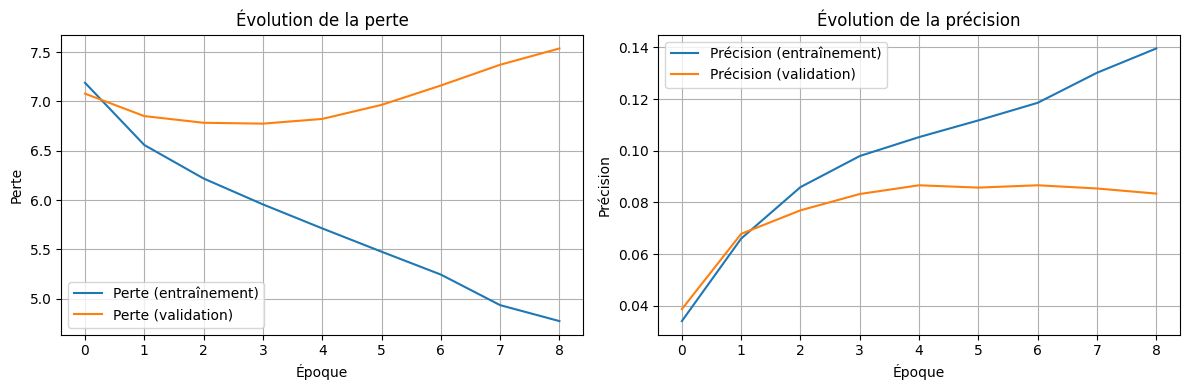

In [10]:
# Visualiser l'historique d'entraînement
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Graphique de la perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte (entraînement)')
plt.plot(history.history['val_loss'], label='Perte (validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

# Graphique de la précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision (entraînement)')
plt.plot(history.history['val_accuracy'], label='Précision (validation)')
plt.title('Évolution de la précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Génération de Texte

### 4.1 Fonction de génération

In [11]:
def generate_text(model, seed_text, tokenizer, seq_length, num_words=100, temperature=1.0):
    """
    Génère du texte à partir d'une graine (seed)
    
    Parameters:
    - model: Le modèle entraîné
    - seed_text: Texte de départ
    - tokenizer: Tokenizer utilisé (ou None si tokenisation par caractères)
    - seq_length: Longueur des séquences
    - num_words: Nombre de mots/caractères à générer
    - temperature: Contrôle la créativité (plus élevé = plus créatif, plus bas = plus conservateur)
    """
    generated_text = seed_text.lower()
    
    for _ in range(num_words):
        # Préparer la séquence d'entrée
        if TOKENIZE_BY_CHAR:
            # Pour la tokenisation par caractères
            sequence = [char_to_idx.get(char, 0) for char in generated_text[-seq_length:]]
        else:
            # Pour la tokenisation par mots
            # Tokeniser le texte généré jusqu'à présent
            words = generated_text.split()
            # Prendre les derniers mots (jusqu'à seq_length)
            recent_words = words[-seq_length:] if len(words) >= seq_length else words
            # Convertir en séquence d'indices
            sequence = [tokenizer.word_index.get(word, 0) for word in recent_words]
        
        # Pad la séquence si nécessaire
        if len(sequence) < seq_length:
            sequence = [0] * (seq_length - len(sequence)) + sequence
        # Tronquer si trop longue
        elif len(sequence) > seq_length:
            sequence = sequence[-seq_length:]
        
        # Prédire le prochain élément
        sequence = np.array(sequence).reshape(1, seq_length)
        predictions = model.predict(sequence, verbose=0)[0]
        
        # Appliquer la température pour contrôler la créativité
        predictions = np.log(predictions + 1e-10) / temperature
        exp_predictions = np.exp(predictions)
        predictions = exp_predictions / np.sum(exp_predictions)
        
        # Échantillonner selon la distribution de probabilité
        next_index = np.random.choice(len(predictions), p=predictions)
        
        # Ajouter le nouvel élément au texte généré
        if TOKENIZE_BY_CHAR:
            next_char = idx_to_char.get(next_index, '')
            if next_char:
                generated_text += next_char
        else:
            next_word = tokenizer.index_word.get(next_index, '')
            if next_word:
                generated_text += ' ' + next_word
    
    return generated_text

# Fonction pour générer du texte avec différentes graines
def generate_samples(model, tokenizer, seq_length, seed_texts, num_words=150, temperature=1.0):
    """
    Génère plusieurs échantillons de texte avec différentes graines
    """
    print("="*70)
    print("GÉNÉRATION DE TEXTE")
    print("="*70)
    
    for i, seed in enumerate(seed_texts, 1):
        print(f"\n--- Échantillon {i} ---")
        print(f"Graine: '{seed}'")
        print(f"Température: {temperature}")
        print("-" * 70)
        generated = generate_text(model, seed, tokenizer, seq_length, num_words, temperature)
        print(generated)
        print()

### 4.2 Génération avec différentes graines

In [12]:
# Charger le meilleur modèle si disponible
if os.path.exists('best_model.h5'):
    print("Chargement du meilleur modèle sauvegardé...")
    model.load_weights('best_model.h5')

# Préparer le tokenizer pour la génération
if TOKENIZE_BY_CHAR:
    gen_tokenizer = None
else:
    gen_tokenizer = tokenizer

# Différentes graines pour tester le modèle
seed_texts = [
    "To be or not to be",
    "Romeo and Juliet",
    "All the world's a stage",
    "Double, double toil and trouble",
    "What light through yonder window breaks"
]

# Générer du texte avec température modérée (créativité équilibrée)
generate_samples(model, gen_tokenizer, SEQUENCE_LENGTH, seed_texts, 
                 num_words=200, temperature=0.8)

Chargement du meilleur modèle sauvegardé...
GÉNÉRATION DE TEXTE

--- Échantillon 1 ---
Graine: 'To be or not to be'
Température: 0.8
----------------------------------------------------------------------
to be or not to be timons years duke of thunder with your throat to love your queen king page and the french spring i know our gentle face your coming is free with him and from most man and myself to outlive the strong man o all giving them sins far with him by the book of those simples trinculo it there shall be crowned to be so he is let us drink the archbishop and foreign order with the others exeunt scene iii another part of the palace enter the gentlemen of a john of the forest enter the other enter with the roman palace earl of syracuse with this duke of maid were a man not like a fool with wonder to lay i call thee injury to tell your better friends ay my lord what was the king enter enter in the castle scene iv the same a room in the street scene iii london feast enter enter wi

### 4.3 Expérimentation avec différentes températures

In [13]:
# Tester différentes températures pour voir l'impact sur la créativité
seed = "To be or not to be"
temperatures = [0.5, 1.0, 1.5]

print("="*70)
print("COMPARAISON DES TEMPÉRATURES")
print("="*70)
print(f"Graîne: '{seed}'\n")

for temp in temperatures:
    print(f"\n--- Température: {temp} ---")
    generated = generate_text(model, seed, gen_tokenizer, SEQUENCE_LENGTH, 
                              num_words=150, temperature=temp)
    print(generated)
    print()

COMPARAISON DES TEMPÉRATURES
Graîne: 'To be or not to be'


--- Température: 0.5 ---
to be or not to be a man of the court of thy noble son and take the duke of the king and this woman his son he is not letters and how to him the king hath in the field of a other and the king of the forest of the king of the duke of the king the velvet and with her wit and so do you i have not see a warlike man for a battle of a dream of that as i know you for not the little man of thy own heart of the court of the time of the temple of the ground of it and i shall live i would not have more things that will be her done and you have been a womans and made you but i am thou art not yet for you for my heart i see not time and you shall be no


--- Température: 1.0 ---
to be or not to be some task on his tail the coward now sit in canterbury full of winchester the realm of warwick king margaret where are on four side unmindful because for him for thrift by what it meaning the matter of these such pure a h

## 5. Analyse et Conclusion

### Observations
- Le modèle apprend les patterns et le style de Shakespeare
- La température contrôle le niveau de créativité vs cohérence
- Plus d'époques d'entraînement améliorent généralement la qualité
- La tokenisation par mots donne généralement de meilleurs résultats que par caractères

### Améliorations possibles
- Augmenter le nombre d'époques d'entraînement
- Ajuster l'architecture (plus de couches LSTM, plus d'unités)
- Utiliser des techniques avancées (attention, transformers)
- Augmenter la taille du corpus ou utiliser un corpus plus spécialisé

In [14]:
# Sauvegarder le modèle final et le tokenizer
print("Sauvegarde du modèle et des composants...")

# Sauvegarder le modèle
model.save('shakespeare_lstm_model.h5')
print("✓ Modèle sauvegardé: shakespeare_lstm_model.h5")

# Sauvegarder le tokenizer si on utilise la tokenisation par mots
if not TOKENIZE_BY_CHAR:
    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
    print("✓ Tokenizer sauvegardé: tokenizer.pkl")
    
    # Sauvegarder les paramètres
    params = {
        'vocab_size': vocab_size,
        'sequence_length': SEQUENCE_LENGTH,
        'tokenize_by_char': TOKENIZE_BY_CHAR
    }
    with open('model_params.pkl', 'wb') as f:
        pickle.dump(params, f)
    print("✓ Paramètres sauvegardés: model_params.pkl")
else:
    # Sauvegarder les mappings caractères pour la tokenisation par caractères
    char_mappings = {
        'char_to_idx': char_to_idx,
        'idx_to_char': idx_to_char,
        'vocab_size': vocab_size
    }
    with open('char_mappings.pkl', 'wb') as f:
        pickle.dump(char_mappings, f)
    print("✓ Mappings caractères sauvegardés: char_mappings.pkl")

print("\nSauvegarde terminée!")

Sauvegarde du modèle et des composants...
✓ Modèle sauvegardé: shakespeare_lstm_model.h5
✓ Tokenizer sauvegardé: tokenizer.pkl
✓ Paramètres sauvegardés: model_params.pkl

Sauvegarde terminée!
